In [2]:
import json
import logging
import pandas as pd
import sys
import re
from datetime import datetime
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from ml_pipe.data.database.mongodb import MongoDb

## Analysieren der Karrieredaten

In [9]:
mongo = MongoDb()
collection_name = "CareerData"
candidates = mongo.get({}, collection_name)

candidates[:2]

[{'_id': ObjectId('67f3c76148ead45952e10cfd'),
  'candidate_id': '602345157',
  'education': [{'institution': 'the philipp university of marburg',
    'degree': 'recht',
    'field_of_study': 'unbekanntes fach',
    'location': 'arnstadt, thuringia, germany',
    'startDate': '2025-04-07',
    'endDate': '2025-04-07',
    'duration': '01/10/2007 - 01/03/2014',
    'subjectStudy': ''}],
  'career_history': [{'company': 'dr herwig',
    'position': 'sales development representative',
    'location': 'erfurt, thüringen, deutschland',
    'startDate': '2025-04-07',
    'endDate': '2025-04-07',
    'description': '',
    'duration': '01/06/2024 - present',
    'companyInformation': {'employee_count': 10,
     'profile_url': 'https://www.linkedin.com/company/herwig-software/',
     'activities': [],
     'description': 'Herwig- Field Service and Workforce Management for energy suppliers\n\nOur strength lies in the planning, control and precise documentation of extensive processes. With our s

Analysiert Karrieredaten und gibt ein DataFrame mit:
- Position
- Anzahl des Auftretens
- Durchschnittliche Karriereschritte pro Kandidat mit dieser Position
zurück.

In [11]:
from collections import Counter, defaultdict
import pandas as pd

def analyze_positions(candidates):
    position_counts = Counter()
    position_steps = defaultdict(list)

    for candidate in candidates:
        career = candidate.get("career_history", [])
        positions_seen = set()
        num_steps = len(career)

        for job in career:
            position = job.get("position")
            if position:
                clean_pos = position.lower().strip()
                position_counts[clean_pos] += 1

                # pro Kandidat nur 1x pro Position zählen
                if clean_pos not in positions_seen:
                    position_steps[clean_pos].append(num_steps)
                    positions_seen.add(clean_pos)

    data = []
    for position, count in position_counts.items():
        avg_steps = (
            sum(position_steps[position]) / len(position_steps[position])
            if position_steps[position]
            else 0
        )
        data.append({
            "Position": position,
            "Anzahl": count,
            "⌀ Schritte/Kandidat": round(avg_steps, 2)
        })

    return pd.DataFrame(data).sort_values(by="Anzahl", ascending=False)

analyze_positions(candidates)

,Position,Anzahl,⌀ Schritte/Kandidat
0,sales development representative,356,6.12
122,account executive,320,7.19
12,business development representative,172,6.29
101,sales manager,131,6.96
60,sales representative,77,5.49
...,...,...,...
1439,brand managerin products & alliances,1,11.00
1440,"brand managerin products & alliances, media markt",1,11.00
1441,"brand managerin, germany/spain/portugal - medi...",1,11.00
1442,"account-managerin, media markt national",1,11.00


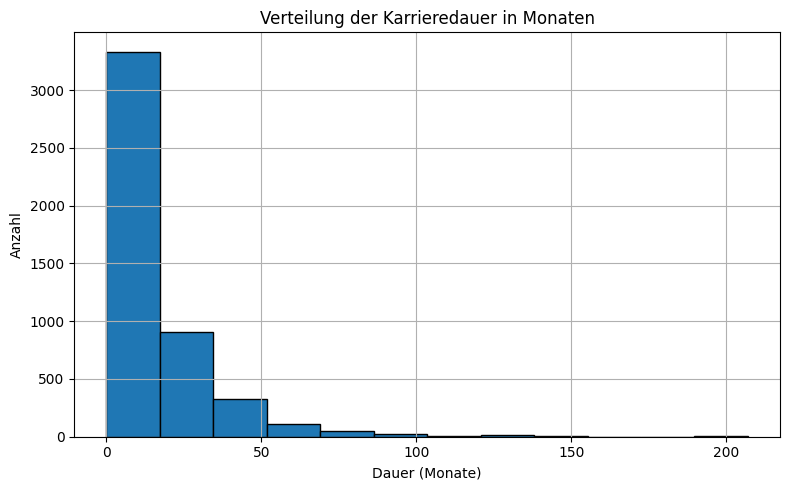

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from datetime import datetime
import re

# Beispiel: Mongo-Abfrage (hier ersetzt du das mit deinem echten Call)
# candidates = mongo.get({}, "CareerData")

# Hilfsfunktion: Dauer in Monaten berechnen aus "01/01/2020 - 01/06/2021"
def parse_duration_to_months(duration_str):
    try:
        start_str, end_str = [s.strip().lower() for s in duration_str.split('-')]
        start_date = datetime.strptime(start_str, "%d/%m/%Y")
        if 'present' in end_str:
            end_date = datetime.now()
        else:
            end_date = datetime.strptime(end_str, "%d/%m/%Y")
        return (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
    except Exception as e:
        return None

# Schritt 1: Daten auslesen und bereinigen
records = []
for candidate in candidates:
    for job in candidate.get("career_history", []):
        position = job.get("position", "Unbekannt").strip().lower()
        duration = job.get("duration", "")
        duration_months = parse_duration_to_months(duration)
        if duration_months is not None:
            records.append({
                "position": position,
                "duration_months": duration_months
            })

# Schritt 2: In DataFrame umwandeln
df = pd.DataFrame(records)

# Schritt 3: Visualisierungen

## 2. Verteilung der Dauer in Monaten (Histogramm)
plt.figure(figsize=(8, 5))
plt.hist(df['duration_months'], bins=12, edgecolor='black')
plt.title("Verteilung der Karrieredauer in Monaten")
plt.xlabel("Dauer (Monate)")
plt.ylabel("Anzahl")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression

# === Hilfsfunktionen ===
def parse_date(date_str):
    for fmt in ("%Y-%m-%d", "%d/%m/%Y"):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Unbekanntes Datumsformat: {date_str}")

def months_between(start, end):
    start_date = parse_date(start)
    end_date = parse_date(end)
    delta = relativedelta(end_date, start_date)
    return delta.years * 12 + delta.months

trend_results = []

for candidate in candidates:
    durations = []

    for job in candidate.get("career_history", []):
        start = job.get("startDate")
        end = job.get("endDate")
        if start and end:
            try:
                duration = months_between(start, end)
                durations.append(duration)
            except Exception as e:
                continue

    if len(durations) >= 3:
        X = np.arange(len(durations)).reshape(-1, 1)
        y = np.array(durations)

        model = LinearRegression()
        model.fit(X, y)
        coef = model.coef_[0]

        if coef > 0.5:
            label = "Stabil (steigend)"
        elif coef < -0.5:
            label = "Springer (fallend)"
        else:
            label = "Konstant"

        trend_results.append({
            "Karriereschritte": len(durations),
            "⌀ Verweildauer": round(np.mean(durations), 2),
            "Trend (Reg.-Koeff.)": round(coef, 2),
            "Wechseltyp": label
        })

# Als Tabelle anzeigen
df = pd.DataFrame(trend_results)
print(df)

     Karriereschritte  ⌀ Verweildauer  Trend (Reg.-Koeff.) Wechseltyp
0                   8             0.0                  0.0   Konstant
1                   5             0.0                  0.0   Konstant
2                   7             0.0                  0.0   Konstant
3                  18             0.0                  0.0   Konstant
4                   5             0.0                  0.0   Konstant
..                ...             ...                  ...        ...
972                11             0.0                  0.0   Konstant
973                 3             0.0                  0.0   Konstant
974                 3             0.0                  0.0   Konstant
975                 4             0.0                  0.0   Konstant
976                 7             0.0                  0.0   Konstant

[977 rows x 4 columns]


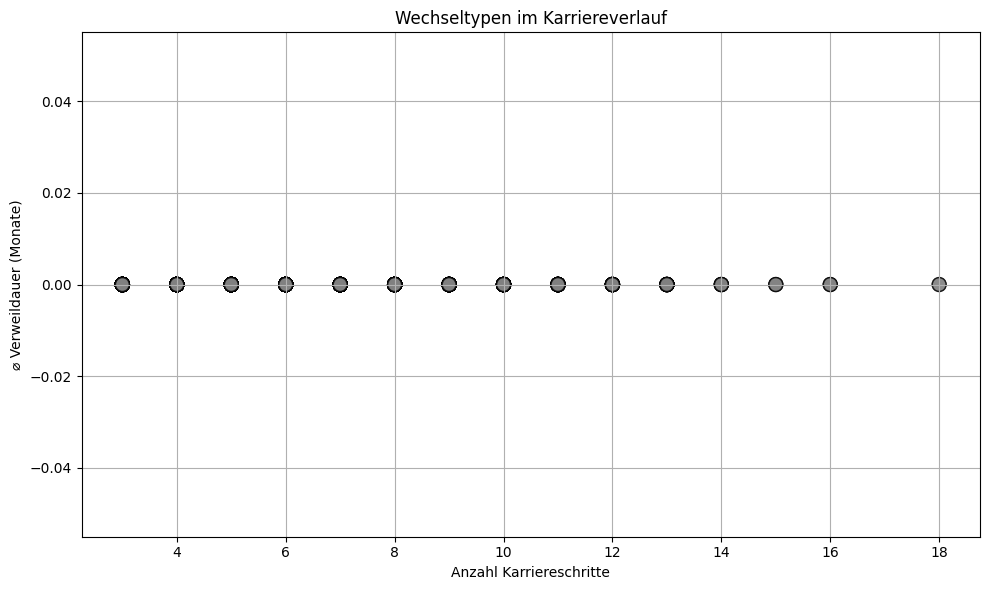

In [14]:
# Farben je Typ
farbe = {
    "Konstant": "gray",
    "Springer (fallend)": "red",
    "Stabil (steigend)": "green"
}
farben = df["Wechseltyp"].map(farbe)

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df["Karriereschritte"], df["⌀ Verweildauer"], c=farben, s=100, edgecolors="black", alpha=0.7)

plt.xlabel("Anzahl Karriereschritte")
plt.ylabel("⌀ Verweildauer (Monate)")
plt.title("Wechseltypen im Karriereverlauf")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
from dateutil import parser

# Robust einzelnes Datum parsen
def parse_date(date_str):
    if not date_str or str(date_str).lower().strip() in ["present", "heute", "now", ""]:
        return datetime.now()
    try:
        return parser.parse(date_str, dayfirst=True)
    except Exception as e:
        raise ValueError(f"Unbekanntes Datumsformat: {date_str} → {e}")

# Monate berechnen
def months_between(start, end):
    delta = relativedelta(end, start)
    return delta.years * 12 + delta.months

# Ergebnisliste
results = []

# Durch alle Kandidaten iterieren
for candidate in candidates:
    durations = []
    for job in candidate.get("career_history", []):
        start_raw = job.get("startDate")
        end_raw = job.get("endDate")
        
        try:
            start = parse_date(start_raw)
            end = parse_date(end_raw)
            duration = months_between(start, end)
            durations.append(duration)
        except Exception as e:
            print("Fehler bei:", start_raw, "-", end_raw, "→", e)
    
    if len(durations) < 2:
        continue  # überspringe Kandidaten mit unzureichendem Verlauf

    months_since_last_change = durations[-1]
    past_durations = durations[:-1]
    avg_past_duration = sum(past_durations) / len(past_durations) if past_durations else 0

    results.append({
        "candidate_id": candidate.get("candidate_id", "unknown"),
        "Aktuelle Verweildauer": months_since_last_change,
        "⌀ Frühere Verweildauer": round(avg_past_duration, 2),
        "Über Durchschnitt?": months_since_last_change > avg_past_duration
    })

# Als DataFrame anzeigen
df = pd.DataFrame(results)
print(df.head())


Fehler bei: {'month': 9, 'year': 2024} - None → Unbekanntes Datumsformat: {'month': 9, 'year': 2024} → Parser must be a string or character stream, not dict
Fehler bei: {'month': 1, 'year': 2024} - {'month': 6, 'year': 2024} → Unbekanntes Datumsformat: {'month': 1, 'year': 2024} → Parser must be a string or character stream, not dict
Fehler bei: {'month': 8, 'year': 2017} - {'month': 10, 'year': 2023} → Unbekanntes Datumsformat: {'month': 8, 'year': 2017} → Parser must be a string or character stream, not dict
Fehler bei: {'month': 1, 'year': 2024} - None → Unbekanntes Datumsformat: {'month': 1, 'year': 2024} → Parser must be a string or character stream, not dict
Fehler bei: {'month': 4, 'year': 2022} - {'month': 1, 'year': 2023} → Unbekanntes Datumsformat: {'month': 4, 'year': 2022} → Parser must be a string or character stream, not dict
Fehler bei: {'month': 9, 'year': 2018} - {'month': 3, 'year': 2022} → Unbekanntes Datumsformat: {'month': 9, 'year': 2018} → Parser must be a string